In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import category_encoders as ce
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
data=pd.read_csv("C:/Users/rohan/Downloads/Fraud_check.csv")
data

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


In [3]:
data.isna().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [4]:
data.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


<AxesSubplot:ylabel='Count'>

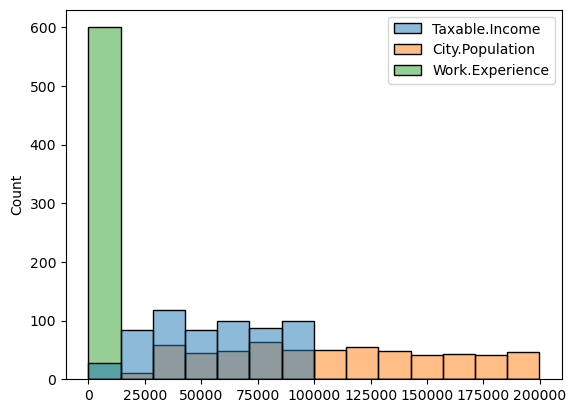

In [6]:
sns.histplot(data)

<AxesSubplot:>

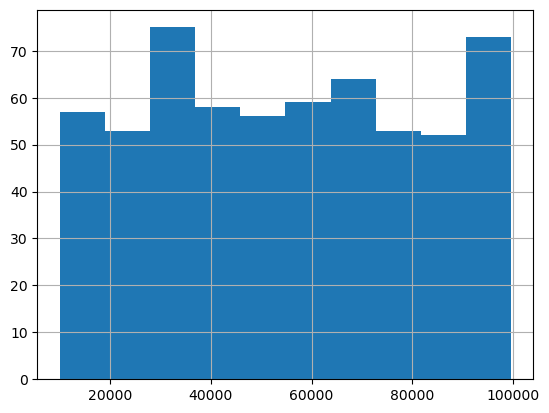

In [7]:
data["Taxable.Income"].hist()


In [8]:
encoder = ce.OrdinalEncoder(cols=['Undergrad', 'Marital.Status', 'Urban'])
fraud_check = encoder.fit_transform(data)

In [9]:
fraud_check_val = []
for value in data['Taxable.Income']:
    if value <= 30000:
        fraud_check_val.append("Risky")
    else:
        fraud_check_val.append("Good")
        
fraud_check["fc_val"]= fraud_check_val

In [10]:
fraud_check.head()


,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,fc_val
0,1,1,68833,50047,10,1,Good
1,2,2,33700,134075,18,1,Good
2,1,3,36925,160205,30,1,Good
3,2,1,50190,193264,15,1,Good
4,1,3,81002,27533,28,2,Good


In [12]:
#train test split
x = fraud_check.drop(['fc_val', 'Taxable.Income'],axis=1)
y = fraud_check['fc_val']
x

,Undergrad,Marital.Status,City.Population,Work.Experience,Urban
0,1,1,50047,10,1
1,2,2,134075,18,1
2,1,3,160205,30,1
3,2,1,193264,15,1
4,1,3,27533,28,2
...,...,...,...,...,...
595,2,2,39492,7,1
596,2,2,55369,2,1
597,1,2,154058,0,1
598,2,3,180083,17,2


In [13]:
y

0      Good
1      Good
2      Good
3      Good
4      Good
       ... 
595    Good
596    Good
597    Good
598    Good
599    Good
Name: fc_val, Length: 600, dtype: object

In [14]:
y.value_counts()

Good     476
Risky    124
Name: fc_val, dtype: int64

In [15]:
#Random Forest Classification
num_trees = 100
max_features = 4
kfold = KFold(n_splits=20,shuffle=True)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results_rfc = cross_val_score(model, x, y, cv=kfold)
print(results_rfc.mean()*100)

73.83333333333333


In [16]:
#Bagging
from sklearn.ensemble import BaggingClassifier

seed = 7
kfold = KFold(n_splits=20, random_state=seed, shuffle=True)
cart = DecisionTreeClassifier()
num_trees = 100
model1 = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
results_bag = cross_val_score(model1, x, y, cv=kfold)
print(results_bag.mean()*100)

73.50000000000001


In [17]:
#Boosting
from sklearn.ensemble import AdaBoostClassifier

num_trees = 100
seed=7
kfold = KFold(n_splits=20, random_state=seed, shuffle=True)
model2 = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
results_boost = cross_val_score(model2, x, y, cv=kfold)
print(results_boost.mean()*100)

77.00000000000001


In [18]:
#Stacking
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [19]:
# create the sub models
estimators = []
model3 = LogisticRegression(max_iter=500)
estimators.append(('logistic', model3))
model4 = DecisionTreeClassifier()
estimators.append(('cart', model4))
model5 = SVC()
estimators.append(('svm', model5))

# create the ensemble model
ensemble = VotingClassifier(estimators)
results_stack = cross_val_score(ensemble, x, y, cv=kfold)
print(results_stack.mean()*100)

79.33333333333333


In [ ]:
Conclusion: Stacking technique has a great accuracy 79.33%